### clustering


#### library import

In [24]:
!pip install --upgrade pandas-profiling
!pip install pydantic-settings
!pip install ydata-profiling



You should consider upgrading via the '/Users/hankuklee/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/hankuklee/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/hankuklee/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip' command.


In [50]:
import pandas as pd               # for data manipulation
import numpy as np                # for aggregation functions
import gc                         # for clean-up memory
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import random
from ydata_profiling import ProfileReport

from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans


### data processing
#### 1. data load

In [26]:
path = '../dataset/'
random_sate = 1234

In [27]:
# sampling
orders = pd.read_csv(path + 'orders.csv')
orders_10_sampled = orders.sample(frac=0.01, random_state=42)
orders_10_sampled.to_csv(path + 'orders' + '_sampled.csv', index=False)

order_products__prior = pd.read_csv(path + 'order_products__prior.csv')
order_products__prior_10_sampled = order_products__prior.sample(frac=0.1, random_state=42)
order_products__prior_10_sampled.to_csv(path + 'order_products__prior' + '_sampled.csv', index=False)

order_products__train = pd.read_csv(path + 'order_products__train.csv')
order_products__train_10_sampled = order_products__train.sample(frac=0.1, random_state=42)
order_products__train_10_sampled.to_csv(path + 'order_products__train' + '_sampled.csv', index=False)



In [28]:

orders = pd.read_csv(path + 'orders' + '_sampled.csv')
order_products__prior = pd.read_csv(path + 'order_products__prior' + '_sampled.csv')
order_products__train = pd.read_csv(path + 'order_products__train' + '_sampled.csv')

print(orders.columns)

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


In [29]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1725437,89960,prior,5,0,14,14.0
1,1122088,157793,prior,6,3,8,4.0
2,352443,118560,prior,1,5,11,NaN
3,2225015,182324,prior,16,6,13,6.0
4,1083635,87386,prior,10,1,10,4.0


In [30]:
products = pd.read_csv(path + 'products.csv')

products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [31]:
print("중복된 항목 수: ", len(orders[orders.duplicated()]))

중복된 항목 수:  0


In [32]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34211 entries, 0 to 34210
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34211 non-null  int64  
 1   user_id                 34211 non-null  int64  
 2   eval_set                34211 non-null  object 
 3   order_number            34211 non-null  int64  
 4   order_dow               34211 non-null  int64  
 5   order_hour_of_day       34211 non-null  int64  
 6   days_since_prior_order  32153 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 1.8+ MB


In [33]:
# unique 값 확인
for column_name in list(orders.columns):
    print(column_name, orders[column_name].dtype, orders[column_name].unique())

order_id int64 [1725437 1122088  352443 ...  244946 2201591 1831310]
user_id int64 [ 89960 157793 118560 ... 167865 166339  47507]
eval_set object ['prior' 'train' 'test']
order_number int64 [  5   6   1  16  10  14  38  49   8  47  17   2  15   4  42   3  37  31
  67  57   9  36  39  20   7  13  45  28  25  19  22  27  62  18  23  33
  30  12  29  26  24  44  11  40  34  55  46  93  99  41  85  35  86  75
  48  32  51  21  43  60  71  92  69  87  65  79  54  58  56  53  89  70
  88  72  98  59  68  63  78  64  52  83  77  61  80  50  74  91  81  73
  82  90  66  84  97 100  76  95  94  96]
order_dow int64 [0 3 5 6 1 2 4]
order_hour_of_day int64 [14  8 11 13 10 15 20  7  9 21 17 16 18 12 19 22  5  6 23  4  1  0  3  2]
days_since_prior_order float64 [14.  4. nan  6. 18.  8.  2.  5. 20.  3. 12. 24. 30.  7.  9.  1.  0. 13.
 26. 28. 10. 15. 17. 25. 27. 11. 21. 16. 23. 19. 29. 22.]


In [34]:
list_categorical_columns = list(orders.select_dtypes(include=['string', 'object']).columns)
list_numeric_columns = list(orders.select_dtypes(include=['float64', 'int64']).columns)


print(len(orders.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

7
1
6


In [35]:
orders.isna().sum()

order_id                     0
user_id                      0
eval_set                     0
order_number                 0
order_dow                    0
order_hour_of_day            0
days_since_prior_order    2058
dtype: int64

In [36]:
# na 값이 있는 컬럼 확인
orders.columns[orders.isna().sum() != 0]

Index(['days_since_prior_order'], dtype='object')

### independent Data Explore
#### 1) Categorical data analysis

In [37]:
# 불필요한 컬럼 확인
orders[list_categorical_columns].nunique().sort_values()

# 휴리스틱 접근
orders.head(3)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1725437,89960,prior,5,0,14,14.0
1,1122088,157793,prior,6,3,8,4.0
2,352443,118560,prior,1,5,11,NaN


<Axes: xlabel='order_id', ylabel='Count'>

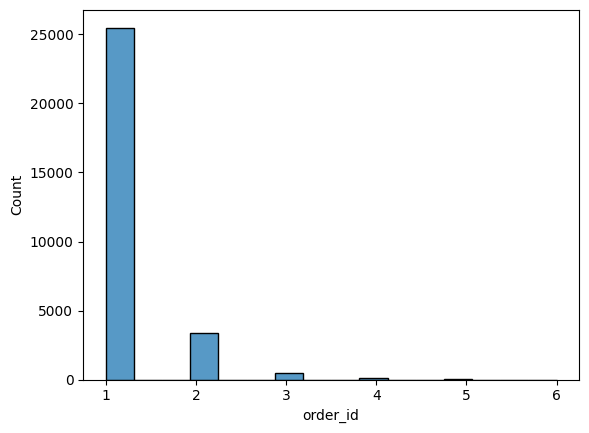

In [38]:
# user_id별로 얼마나 구매했나?
sns.histplot(orders.groupby('user_id').count()['order_id'])

# sns.histplot(orders.groupby('user_id').count())


In [39]:
list_numeric_columns

['order_id',
 'user_id',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

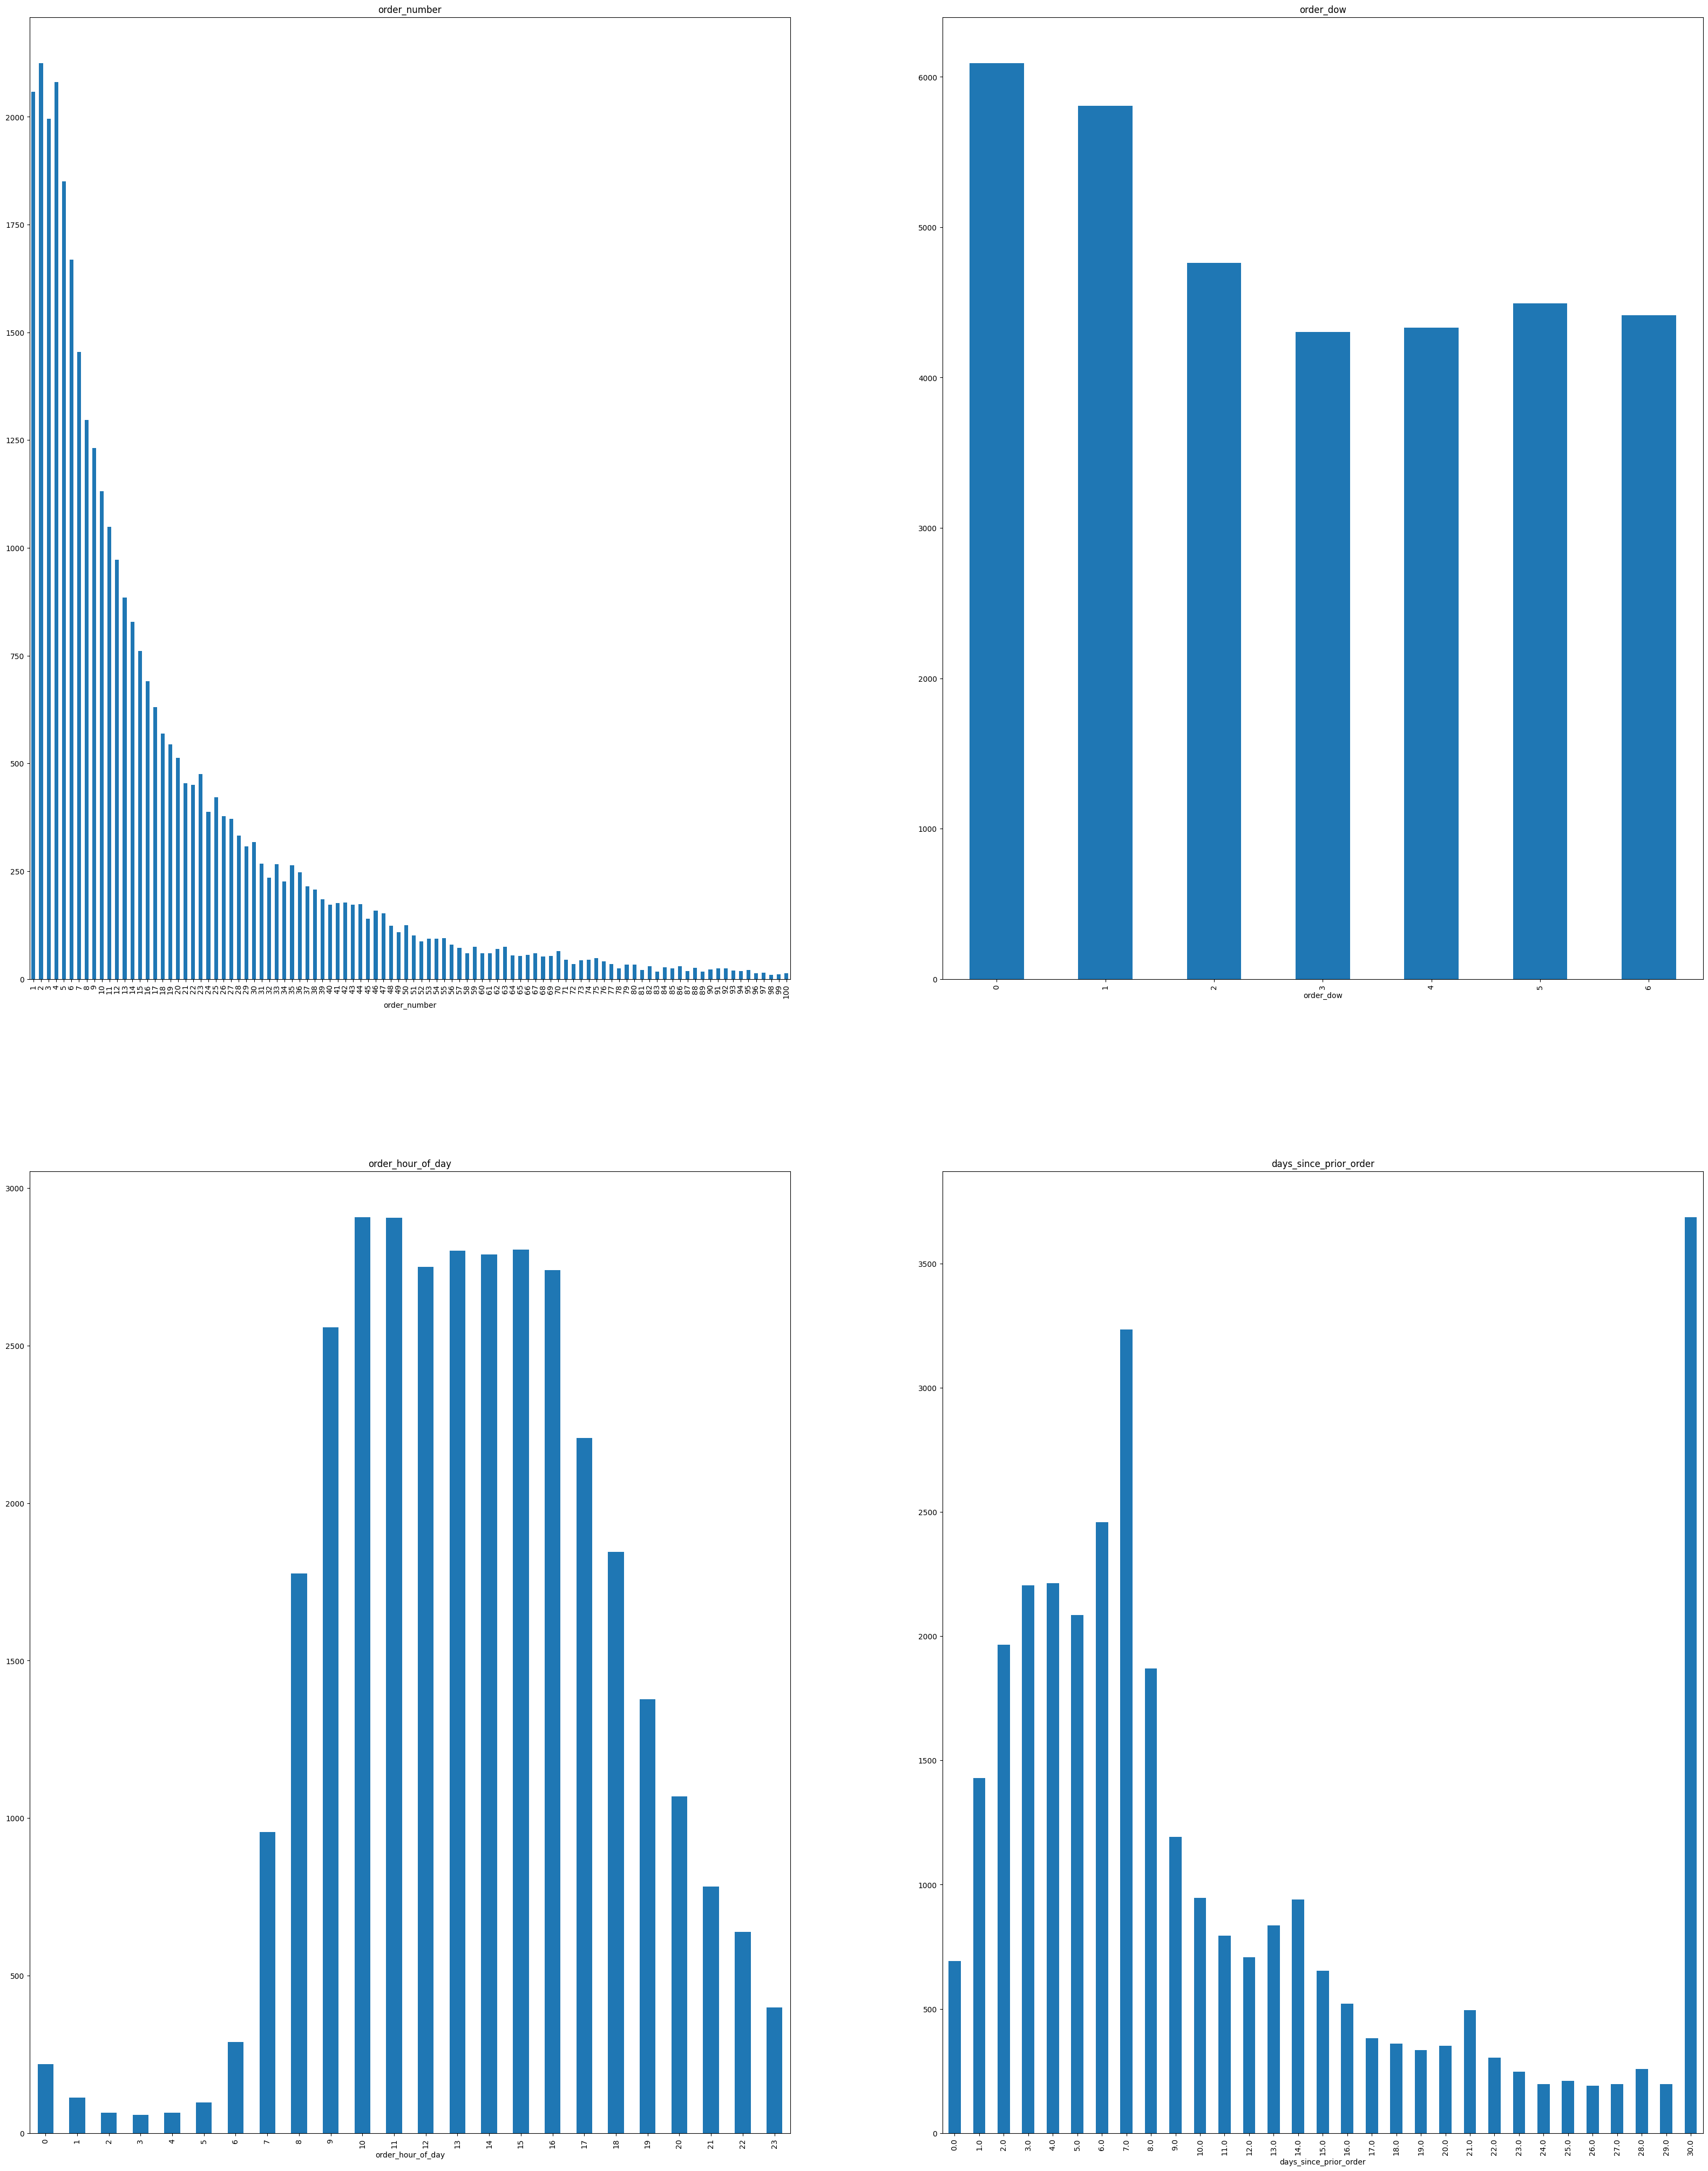

In [40]:
# column 별 분포 확인

plt.figure(figsize=(40, 40))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    if column_name == 'user_id' or column_name == 'order_id':
        continue
    plt.subplot(2, 2, x)
    x = x + 1
    orders[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()


In [41]:
# skew and kur

print("")
# skew(orders['user_id'])
# kurtosis(orders['user_id])


### EDA with pandas_profiling

In [42]:
# orders.profile_report().to_file('eda_pandasprofiling.html')
# profile = ProfileReport(orders, title="Profiling Report")

# profile.to_file('eda_pandasprofiling.html')

### 군집화
#### Feature Engineering


In [43]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34211 entries, 0 to 34210
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34211 non-null  int64  
 1   user_id                 34211 non-null  int64  
 2   eval_set                34211 non-null  object 
 3   order_number            34211 non-null  int64  
 4   order_dow               34211 non-null  int64  
 5   order_hour_of_day       34211 non-null  int64  
 6   days_since_prior_order  32153 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 1.8+ MB


In [62]:
# user 별로 그룹화를 시켜줌
# user_id 별로 구매 횟수, user_id 별로 재구매한 제품 등
# pivot_table?
# 각각의 row를 column으로 올려줌
# user 별로 어떤 제품을 구매했는지, 구매한 횟수는 어떻게 되는지, 구매한 날짜 등을 알 수 있음
orders.isna().sum().sort_values()

# help(orders.pivot_table)

orders.head(5)

orders_pivot = orders.pivot_table(index=orders.index, columns='user_id', values=['order_number'], aggfunc=['first', 'count']).fillna(0)



KeyError: 'product_id'

In [61]:
display(orders_pivot)

count                                                          \
        order_number                                                           
user_id       19     24     27     33     37     40     45     52     54       
0                0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1                0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3                0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4                0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...              ...    ...    ...    ...    ...    ...    ...    ...    ...   
34206            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34207            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34208            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34209            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34210            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                ...                                                          \
                ...                                                           
user_id 57      ... 206164 206174 206176 206178 206179 206189 206198 206201   
0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...        ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
34206      0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34207      0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34208      0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34209      0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34210      0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                       
                       
user_id 206206 206207  
0          0.0    0.0  
1          0.0    0.0  
2          0.0    0.0  
3          0.0    0.0  
4          0.0    0.0  
...        ...    ...  
34206      0.0    0.0  
34207      0.0    0.0  
34208      0.0    0.0  
34209      0.0    0.0  
34210      0.0    0.0  

[34211 rows x 29496 columns]

In [45]:
# columns 합치기
orders_pivot.columns = ['_'.join(col) for col in orders_pivot.columns.values]

TypeError: sequence item 2: expected str instance, int found

### Feature Transformation
#### Normalization
* Standardization과 Normalization은 다른 것
* Normalization은 [0, 1]로 값을 scaling 하는 것(예 sklearn의 MinMaxScalar())
* Standardization은 정규분포의 표준화를 활용하여 scaling하는 것(예 sklearn의 StandardScaler())



feature 1 -> [0, 1000]
feature 2 -> [0, 1]

    feature 1 feature 2
A       100     0.5
B       500     0.9


상대적으로 보면 100과 500 차이가 0.5, 0.9차이가 비슷한 것 같지만
절대적인 차이는 feature 1이 차이가 많이 남

feature 1 -> [0, 1]
feature 2 -> [0, 1]

    feature 1 feature 2
A       0.1     0.5
B       0.5     0.9


distance를 비슷하게 맞춰야함


In [60]:
scaler = MinMaxScaler()
orders_pivot.loc[:, :] = scaler.fit_transform(orders_pivot)
orders_pivot.head(1)

count                                                          \
        order_number                                                           
user_id       19     24     27     33     37     40     45     52     54       
0                0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                ...                                                          \
                ...                                                           
user_id 57      ... 206164 206174 206176 206178 206179 206189 206198 206201   
0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                       
                       
user_id 206206 206207  
0          0.0    0.0  

[1 rows x 29496 columns]

MinMaxScaler란?

* FeatureTransformation(Scaling) 기법
* (X - (X의 최소값) / (X의 최대값 - X의 최솟값))

In [ ]:
x_min = orders_pivot['count_order_number'].min()
x_max = orders_pivot['count_order_number'].max()
print(x_min)
print(x_max)


In [ ]:
(orders_pivot['count_order_number'] - x_min) / (x_max - x_min)


최종 생성 Feature는 아래와 같은 특성을 가짐
1. pivoting by Product Data ->
2. aggregation by user_id (특정 유저가 제품을 구매한 횟수)

### Model Analysis
#### Model Optimization with K-means Algorithm

* K-Means 알고리즘은 비지도학습 중에서 가장 대표적인 클러스터링 알고리즘입니다. 클러스터링은 데이터를 비슷한 특성을 가진 그룹으로 나누는 작업을 의미한다.
* K-Means 알고리즘은 매우 빠르고 간단한 구현으로도 좋은 성능을 보여주는 알고리즘 중 하나이지만, 초기 클러스터 중심값 선택이나 클러스터 개수 선택 등 초기 설정이 클러스터링 성능에 영향을 미친다.
* 알고리즘의 동작 순서

1. 초기 클러스터 중심값 지정
2. 모든 데이터 포인트들을 가장 가까운 클러스터에 할당
3. 할당된 클러스터에 대해 클러스터 중심값을 재계산
4. 2-3과정을 반복하여 클러스터 중심값과 할당을 업데이트

* 이 알고리즘에서 K개의 클러스터 중심값은 초기에 무작위로 선택된다. 그리고 각 데이터 포인트는 가장 가까운 클러스터 중심값에 할당된다. 이후 할당된 데이터 포인트를 이용해 해당 클러스터의 중심값을 계산한다. 클러스터 중심값이 업데이트되면 각 데이터 포인트는 가장 가까운 클러스터 중심값에 할당된다. 이 과정을 클러스터 할당과 중심값 계산이 변화가 없을 떄 까지 반복한다.




In [ ]:
sum_of_squared_distances = []
K = range(2, 20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(orders_pivot)
    sum_of_squared_distances.append(km.inertia_)


In [ ]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')

plt.title('Elbow method for optimal k')
plt.show()

Elbow Method는 클러스터 개수(K)를 변화시켜가면서 K-Means 알고리즘을 수행한 결과를 나타낸 그래프에서, 그래프 모양이 팔꿈치(Elbow) 모양을 띄는 지점에서 최적의 클러스터 개수를 결정하는 방법
이 방법은 클러스터 개수를 점차 증가시켜가면서 K-Means 알고리즘을 실행하고, 각 클러스터마다 제곱 오차합(SSE, Sum of squared Errors)를 구한되 이를 그래프로 나타냄.

그래프에서 클러스터 개수(K)가 증가함에 따라 SSE는 감소하게 되며, 이는 클러스터 개수(K)가 증가하면 각 클러스터에 할당된 데이터 포인트들과 해당 클러스터의 중심점과의 거리가 줄어들기 떄문, 그리고 그래프에서 SSE의 증감폭이 크게 줄어드는 팔꿈치 모양을 띄는 지점에서 최적의 클러스터 개수를 결정.

# k = 8 is elbow

In [ ]:
km_final = KMeans(n_clusters=8)
km_final = km_final.fit(orders_pivot)



In [ ]:
km_final.predict(orders_pivot)

In [ ]:
orders_pivot['cluster_number'] = km_final.predict(orders_pivot)

In [ ]:
# 클러스터별 평균값
# 평균 데이터를 구할 수 있음
cluster_result = orders_pivot.groupby['cluster_number'].agg(np.mean)

In [ ]:
len(cluster_result.columns)

In [ ]:
cluster_result.iloc[:, :26]

# 각 군집을 확인할 수 있음

cluster_result.iloc[:, 26:]


---
데이터 샘플링: 전체 데이터셋의 일부를 사용하여 초기 분석을 수행합니다.

희소 행렬 사용: 메모리 사용량을 줄이기 위해 희소 행렬을 사용합니다.

점진적 학습: Incremental PCA와 MiniBatch K-Means를 사용하여 메모리 효율적으로 클러스터링을 수행합니다.


In [70]:
# 사용자 ID와 제품 ID를 결합하여 사용자-아이템 상호작용 데이터 생성
merged_data = pd.merge(orders[['order_id', 'user_id']], order_products__prior[['order_id', 'product_id']], on='order_id')

# 사용자별 구매 빈도 계산
user_product_counts = merged_data.groupby(['user_id', 'product_id']).size().reset_index(name='count')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# user_product_counts

user_product_counts

,user_id,product_id,count
0,27,33787,1
1,33,37131,1
2,37,17170,1
3,37,19048,1
4,37,31727,1
...,...,...,...
32423,206201,20119,1
32424,206201,28625,1
32425,206201,39681,1
32426,206201,49683,1


In [ ]:
orders_pivot = user_product_counts.pivot_table(index=user_product_counts.index, columns='product_id', values=['order_number'], aggfunc=['first', 'count']).fillna(0)


In [56]:
# Pivot Table 대신 희소 행렬 사용
user_product_pivot = user_product_counts.pivot(index='user_id', columns='product_id', values='count').fillna(0)
sparse_user_product_matrix = csr_matrix(user_product_pivot)

# 데이터 스케일링
scaler = StandardScaler(with_mean=False)
user_product_scaled = scaler.fit_transform(sparse_user_product_matrix)

# Incremental PCA를 사용하여 차원 축소
ipca = IncrementalPCA(n_components=50, batch_size=500)
user_product_reduced = ipca.fit_transform(user_product_scaled)

# MiniBatch K-Means 클러스터링 수행
mbk = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=500)
mbk.fit(user_product_reduced)

# 클러스터 레이블 할당
user_product_pivot['cluster'] = mbk.labels_

In [57]:
user_product_pivot

product_id,1,4,10,11,23,25,29,32,34,36,...,49630,49633,49638,49640,49644,49652,49655,49667,49683,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
206178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
206179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


* 너무 sparse 데이터 분포를 띄면, 이를 최소화 할 수 있는 데이터 가공법을 고려한다.
    * category 데이터를 활용하여 sparse 함을 줄인다.

* 타겟(label)이 없는 경우는 클러스터링을 활용한다.

* K-means 알고리즘은 k 수를 설정해줘야 한다. 이를 optimization 할 수 있다.

In [73]:
# 1. 데이터 로드 및 전처리
import pandas as pd

# 데이터 로드
orders = pd.read_csv(path + 'orders_sampled.csv')
order_products_prior = pd.read_csv(path +  'order_products__prior_sampled.csv')
products = pd.read_csv(path + 'products.csv')

# 사용자 ID와 제품 ID를 결합하여 사용자-아이템 상호작용 데이터 생성
merged_data = pd.merge(orders[['order_id', 'user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']], 
                       order_products_prior[['order_id', 'product_id', 'reordered']], 
                       on='order_id')

display(merged_data)

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1725437,89960,0,14,14.0,11250,1
1,1122088,157793,3,8,4.0,45200,0
2,1122088,157793,3,8,4.0,21405,0
3,1022897,119290,2,14,2.0,32134,1
4,1078578,64761,1,9,3.0,18362,1
...,...,...,...,...,...,...,...
32519,1912589,68507,6,11,7.0,46541,1
32520,1912589,68507,6,11,7.0,45296,1
32521,1908865,163324,5,11,4.0,13176,1
32522,2279743,163848,3,12,30.0,9628,0


In [81]:
# 2. Feature Engineering
# 구매 빈도 계산
user_product_counts = merged_data.groupby(['user_id', 'product_id']).size().reset_index(name='count')

# 재주문 비율 계산
user_reorder_ratio = merged_data.groupby('user_id')['reordered'].mean().reset_index(name='reorder_ratio')

# 구매 다양성 계산
user_product_diversity = user_product_counts.groupby('user_id').size().reset_index(name='unique_product_count')

# 구매 시간대 및 요일 계산
user_order_time = merged_data.groupby('user_id')['order_hour_of_day'].mean().reset_index(name='avg_order_hour')
user_order_dow = merged_data.groupby('user_id')['order_dow'].mean().reset_index(name='avg_order_dow')

# 구매 주기 계산
user_order_cycle = orders.groupby('user_id')['days_since_prior_order'].mean().reset_index(name='avg_days_since_prior_order')

# 특징 데이터프레임 결합
user_features = pd.merge(user_reorder_ratio, user_product_diversity, on='user_id')
user_features = pd.merge(user_features, user_order_time, on='user_id')
user_features = pd.merge(user_features, user_order_dow, on='user_id')
user_features = pd.merge(user_features, user_order_cycle, on='user_id').fillna(0)

display(user_features)

,user_id,reorder_ratio,unique_product_count,avg_order_hour,avg_order_dow,avg_days_since_prior_order
0,27,1.000000,1,13.0,1.0,4.0
1,33,1.000000,1,16.0,2.0,27.0
2,37,0.666667,3,19.0,1.0,10.0
3,40,1.000000,1,9.0,0.0,14.0
4,52,1.000000,1,13.0,5.0,18.0
...,...,...,...,...,...,...
16583,206176,1.000000,1,11.0,5.0,21.0
16584,206178,0.000000,1,18.0,6.0,30.0
16585,206179,0.000000,1,9.0,0.0,0.0
16586,206201,0.400000,5,8.6,1.2,12.0


In [82]:
user_features.columns[user_features.isna().sum() != 0]

Index([], dtype='object')

In [86]:
# 3. 데이터 스케일링 및 K-Means 클러스터링

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 데이터 스케일링
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.drop('user_id', axis=1))

# K-Means 클러스터링 수행
kmeans = KMeans(n_clusters=5, random_state=random_sate)
kmeans.fit(user_features_scaled)

# 클러스터 레이블 할당
user_features['cluster'] = kmeans.labels_

display(user_features)

user_features.to_csv('240613_user_features.csv', index=False)

,user_id,reorder_ratio,unique_product_count,avg_order_hour,avg_order_dow,avg_days_since_prior_order,cluster
0,27,1.000000,1,13.0,1.0,4.0,2
1,33,1.000000,1,16.0,2.0,27.0,1
2,37,0.666667,3,19.0,1.0,10.0,1
3,40,1.000000,1,9.0,0.0,14.0,2
4,52,1.000000,1,13.0,5.0,18.0,2
...,...,...,...,...,...,...,...
16583,206176,1.000000,1,11.0,5.0,21.0,2
16584,206178,0.000000,1,18.0,6.0,30.0,3
16585,206179,0.000000,1,9.0,0.0,0.0,4
16586,206201,0.400000,5,8.6,1.2,12.0,0


요약

	•	구매 빈도: 각 사용자별 특정 제품 구매 횟수.
	•	재주문 비율: 사용자의 재주문 비율.
	•	구매 다양성: 사용자가 구매한 고유 제품의 수.
	•	구매 시간대 및 요일: 사용자의 평균 구매 시간대와 요일.
	•	구매 주기: 사용자의 평균 구매 주기.

이러한 특징을 사용하면 사용자의 구매 패턴을 효과적으로 분석할 수 있으며, K-Means 클러스터링을 통해 유사한 구매 행동을 보이는 사용자 그룹을 찾을 수 있습니다. 각 그룹에 맞춤형 마케팅 전략을 적용하여 고객 만족도를 높이고 매출을 증대시킬 수 있습니다.